# Load trained model parameters on new abstracts.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER-V2'
%cd $path
import random
import utils_train as ut
import net
from transformers import BertForMaskedLM, BertTokenizer
import torch
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
/content/drive/MyDrive/elsevier/Bert-NER-V2


In [2]:
example = "Recent advances in machine-learning interatomic potentials have enabled the efficient modeling of complex atomistic systems with an accuracy that is comparable to that of conventional quantum-mechanics based methods. At the same time, the construction of new machine-learning potentials can seem a daunting task, as it involves data-science techniques that are not yet common in chemistry and materials science. Here, we provide a tutorial-style overview of strategies and best practices for the construction of artificial neural network (ANN) potentials. We illustrate the most important aspects of (a) data collection, (b) model selection, (c) training and validation, and (d) testing and refinement of ANN potentials on the basis of practical examples. Current research in the areas of active learning and delta learning are also discussed in the context of ANN potentials. This tutorial review aims at equipping computational chemists and materials scientists with the required background knowledge for ANN potential construction and application, with the intention to accelerate the adoption of the method, so that it can facilitate exciting research that would otherwise be challenging with conventional strategies."

## Load parameters

In [3]:
CLASSES = {'MATERIAL': 1, 'MLIP': 2, 'PROPERTY': 3,
           'VALUE': 4, 'APPLICATION': 5, 'O': 0}
SEED = 32
MAX_LENGTH = 512
ut.seed_everything(SEED)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)
exp_name = '2024-07-06_b_1_s_321_l_512_w_[0.3, 1.0, 1.0, 1.0, 0.5, 0.5]_l_0.0001'
epoch = 5
parameter_path = path + f'/saved_models/{exp_name}/{exp_name}_e_{epoch}.pt'
model.load_state_dict(torch.load(parameter_path))
model.eval()
print('Model loaded')

config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Model loaded


## Feed text to model

In [4]:
def inference(text_test, model, tokenizer, max_length):
    text_list = ut.split_para(text_test)
    token_list = tokenizer.convert_tokens_to_ids(text_list)
    data_test = torch.tensor(token_list + [0] * (max_length - len(token_list)))[None, :]
    att_mask_test = torch.tensor([1] * len(text_list) + [0] * (max_length - len(text_list)))[None, :]
    y_pred_test = model(data_test, attention_mask=att_mask_test)
    y_pred_test = torch.swapaxes(y_pred_test, 1, 2)
    pred = y_pred_test.max(dim=1)[1][0][:len(text_list)]
    return pred, text_list
pred, text_list = inference(example, model, tokenizerBERT, MAX_LENGTH)

# Show prediction

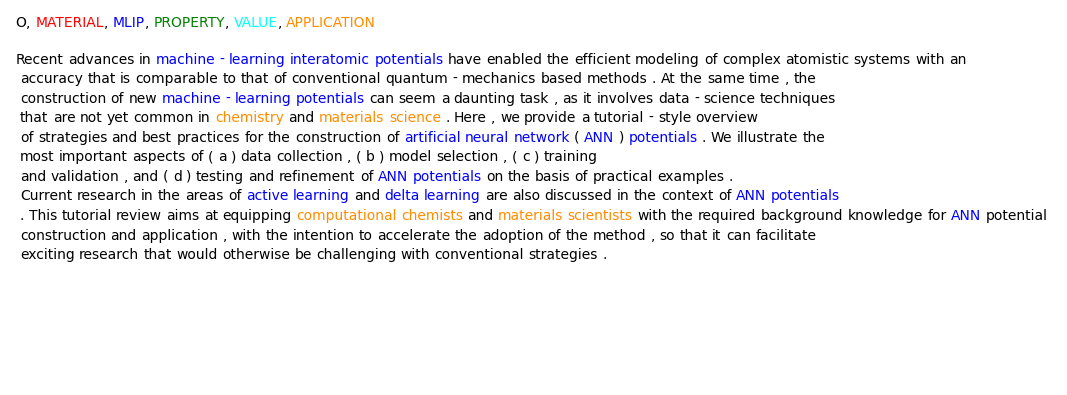

In [5]:
colors = ['black', 'red', 'blue', 'green', 'cyan', 'darkorange']
word_list_marked = ['<' + w + '>' for w in text_list]
markers = [{"color": colors[i]} for i in pred]
j = 0
for i in range(len(text_list)):
    if (i + 1) % 20 == 0:
        word_list_marked.insert(i + j, '\n')
        j += 1
fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <VALUE>, <APPLICATION>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
              highlight_textprops=markers, ax=ax)
plt.show()